## Similarity Use

This part utilizes KMeans_superpatch_fit and segment_TILs from seg.py to segment the TILs with a KMeans model. The model is trained on both a reference patch and a superpatch, and then used to predict clusters on the original reference patch. After clustering, the output of segment_TILs gives a dictionary containing a masks of the TILs, which is then converted to an array. Image_similarity and superpatch_similarity from similarity.py computes the mean squared error between the masks trained on two different models, and plots the reference mask (green) and the superpatch mask (red) on top of the reference image.

In [7]:
# use the github cloned folder path
import os
directory_path = os.getcwd()
repository_path = os.path.dirname(directory_path)

# append paths for importing packages
import sys
sys.path.append(repository_path)

In [27]:
# importing necessary functions
import numpy as np
import zipfile
from tilseg.refine_kmeans import KMeans_superpatch_fit, segment_TILs
from tilseg.similarity import image_similarity, superpatch_similarity
from skimage.measure import regionprops, label

In [9]:
# download to access data from google drive
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 7.8 MB/s eta 0:00:00


In [21]:
# download patch from public google drive folder
!gdown https://drive.google.com/uc?id=1mCpRMSjYk7tuoCUHgrF2MkyZ_yBv_NrI -O 'reference_patch.tif'

mkdir: Image_files: File exists


Downloading...
From: https://drive.google.com/uc?id=1mCpRMSjYk7tuoCUHgrF2MkyZ_yBv_NrI
To: /Users/stanleycho/TILseg_Project2024/Example/reference_patch.tif
100%|██████████████████████████████████████| 36.0M/36.0M [00:02<00:00, 14.4MB/s]


In [24]:
# specify reference patch path
reference_patch = repository_path + '/Example/reference_patch.tif'

# directory of any output folder, does not matter if no files are being saved
output_path = directory_path

Segmenting TILs using a KMeans model fit and clustered/predicted on the same patch:

In [25]:
# obtain cluster mask on reference patch, fitting model on itself
_, _, cluster_mask_dict_reference, _ = segment_TILs(reference_patch,
                                                 output_path,  
                                                 hyperparameter_dict={'n_clusters': 4}, 
                                                 model=None,
                                                 algorithm='KMeans',
                                                 save_TILs_overlay=False,
                                                 save_cluster_masks=False,
                                                 save_all_clusters_img=False,
                                                 save_csv=False,
                                                 multiple_images=False)

# convert cluster mask dictionary from reference patch to array
reference_array = next(iter(cluster_mask_dict_reference.values()))

# filter the array based on contours
reference_array_filtered = np.zeros_like(reference_array)
# use skimage's regionprops to get properties of connected regions
labeled_regions = label(reference_array)
regions = regionprops(labeled_regions)
# filter regions based on circularity and area of a single TIL
for region in regions:
    area = region.area
    perimeter = region.perimeter
    # ensure that the denominator is not zero before calculating circularity
    if area != 0 and perimeter != 0:
        circularity = 4 * np.pi * area / (perimeter ** 2)
        if 200 < region.area < 2000 and circularity > 0.3:
            # add the pixels of the qualified region to the TIL mask
            reference_array_filtered += (labeled_regions == region.label)

Segmenting TILs using a KMeans model prefitted on superpatches:

In [28]:
# download folder which contains 9 superpatch images that have been fed through preprocessing
!gdown https://drive.google.com/uc?id=1OC_ghXoa0hlPu4ZLr5BiEKVwpcgbGFE8 -O 'superpatch_images.zip'

# unzip zip file to get a folder
with zipfile.ZipFile('superpatch_images.zip', 'r') as zip_ref:
    zip_ref.extractall(directory_path)

Downloading...
From (original): https://drive.google.com/uc?id=1OC_ghXoa0hlPu4ZLr5BiEKVwpcgbGFE8
From (redirected): https://drive.usercontent.google.com/download?id=1OC_ghXoa0hlPu4ZLr5BiEKVwpcgbGFE8&confirm=t&uuid=d8b997dc-c72b-49c2-998e-51043339446d
To: /Users/stanleycho/TILseg_Project2024/Example/superpatch_images.zip
100%|██████████████████████████████████████| 1.17G/1.17G [01:41<00:00, 11.6MB/s]
/bin/bash: mk: command not found


Mean squared error for superpatch superpatch20.tif: 0.348


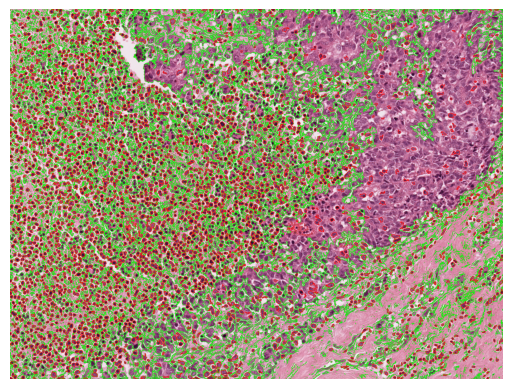

Mean squared error for superpatch superpatch6.tif: 0.346


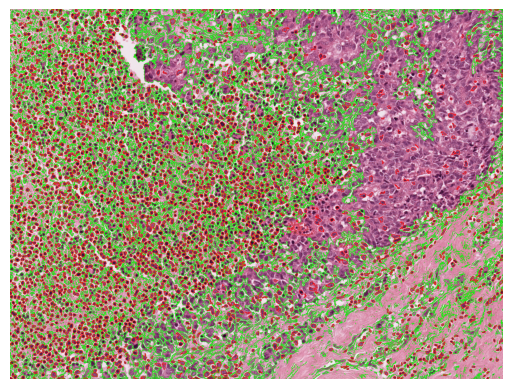

In [4]:
# compute mean squared error and generates image difference for each superpatch in folder; 
# for a superpatch tiff ~200mb, model fitting and segmentation takes ~2-3 minutes
superpatch_folder = directory_path + '/superpatch_images'
superpatch_similarity(superpatch_folder, reference_patch, output_path, reference_array)